In [69]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
from wordcloud import WordCloud

import matplotlib.pyplot as plt

In [62]:
df_vars = pd.read_csv("data/df_vars.csv")
data = pd.read_csv('data/dataraw.csv')

In [25]:
data.head()

,genres,title,tags,specs,price,id,developer
0,"['Action', 'Casual', 'Indie', 'Simulation', 'S...",Lost Summoner Kitty,"['Strategy', 'Action', 'Indie', 'Casual', 'Sim...",['Single-player'],4.99,761140,Kotoshiro
1,"['Free to Play', 'Indie', 'RPG', 'Strategy']",Ironbound,"['Free to Play', 'Strategy', 'Indie', 'RPG', '...","['Single-player', 'Multi-player', 'Online Mult...",0.00,643980,Secret Level SRL
2,"['Casual', 'Free to Play', 'Indie', 'Simulatio...",Real Pool 3D - Poolians,"['Free to Play', 'Simulation', 'Sports', 'Casu...","['Single-player', 'Multi-player', 'Online Mult...",0.00,670290,Poolians.com
3,"['Action', 'Adventure', 'Casual']",弹炸人2222,"['Action', 'Adventure', 'Casual']",['Single-player'],0.99,767400,彼岸领域
4,"['Action', 'Adventure', 'Simulation']",Battle Royale Trainer,"['Action', 'Adventure', 'Simulation', 'FPS', '...","['Single-player', 'Steam Achievements']",3.99,772540,Trickjump Games Ltd


In [63]:
### Función que realiza una transformacion conveniennte y retorna la lista unica de variables:
def unique_list(variable:str):
    # transformar las observaciones 
    data[variable]=data[variable].str.replace('[',"")
    data[variable]=data[variable].str.replace("]","")
    data[variable]=data[variable].str.replace("]","")
    data[variable]=data[variable].str.replace("'","")
    # extraer las especificaciones unicas
    unique_variable_list = list(set(data[variable]))
    unique_variable_list = [i.split(", ") for i in unique_variable_list]
    unique_variable_list = list(set([i[j] for i in unique_variable_list for j in range(len(i))]))
    return unique_variable_list

In [18]:
data.dtypes

genres        object
title         object
tags          object
specs         object
price        float64
id             int64
developer     object
dtype: object

In [12]:
data.nunique()

genres         818
title        27151
tags         13038
specs         3569
price          128
id           27169
developer    10507
dtype: int64

# Precio

In [17]:
data['price'].describe()

count    27170.000000
mean         8.687399
std         14.668457
min          0.000000
25%          2.990000
50%          4.990000
75%          9.990000
max        995.000000
Name: price, dtype: float64

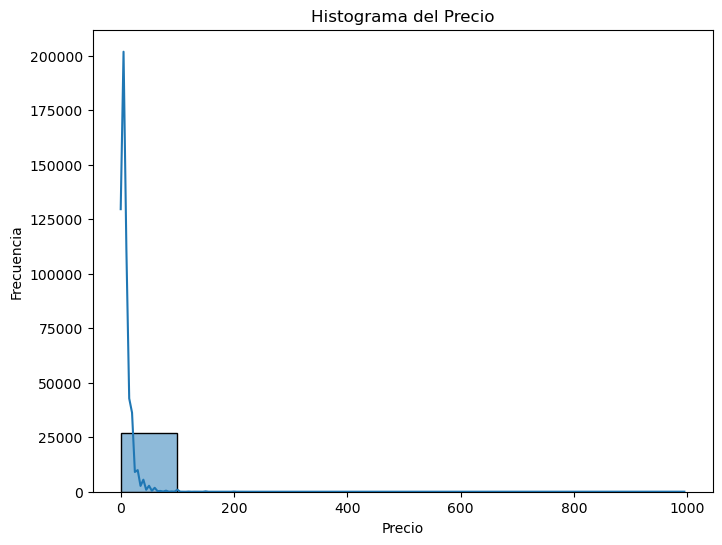

In [23]:
# Histograma
plt.figure(figsize=(8, 6))
sns.histplot(df_vars['Precio'], bins=10, kde=True)
plt.title('Histograma del Precio')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')
plt.show()

Observamos la presencia de Outliers, pues el histograma no se alcanza a visualizar absolutamente

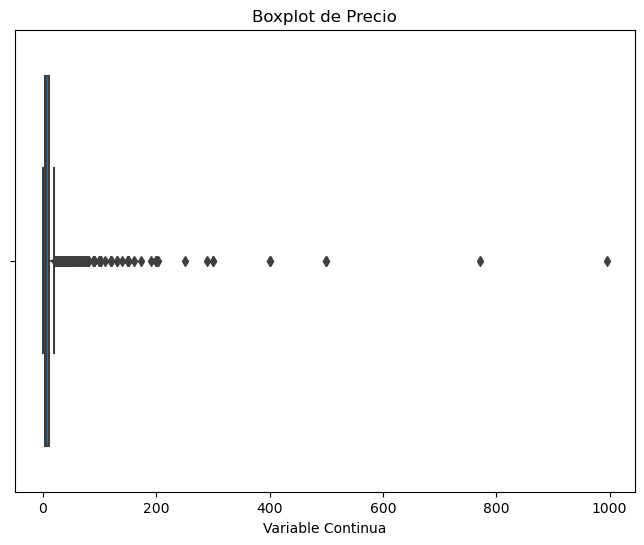

In [27]:
# Boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x=df_vars['Precio'])
plt.title('Boxplot de Precio')
plt.xlabel('Variable Continua')
plt.show()

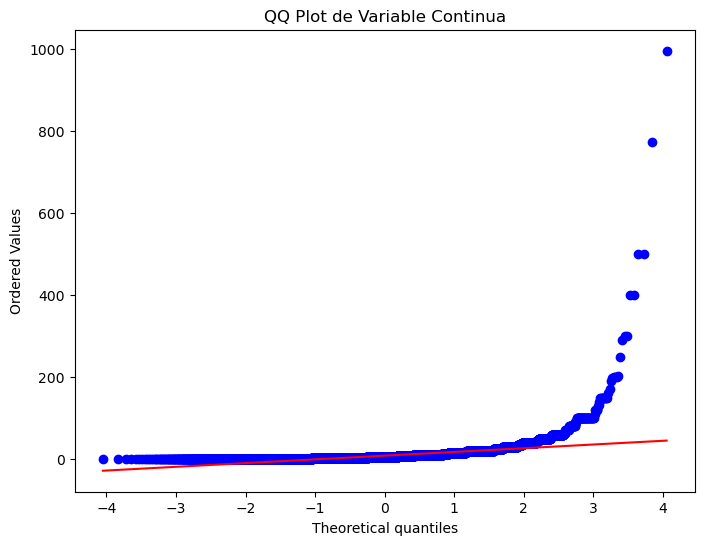

In [29]:
# QQ Plot
plt.figure(figsize=(8, 6))
stats.probplot(df_vars['Precio'], plot=plt)
plt.title('QQ Plot de Variable Continua')
plt.show()

El boxplot y el gráfico de cuantiles nos confirman que hay valores atipicos, lo que nos indica que hay videojuegos con precios muy lejanos a lo estadísticamente estandar.

## detectando outliers

In [41]:
q1, q3= np.percentile(df_vars['Precio'],[25,75])
iqr = q3 - q1
lower_bound = q1 -(1.5 * iqr) 
upper_bound = q3 +(1.5 * iqr)
print(f'Valores atipicos fuera del intervalo: [{lower_bound},{upper_bound}]')

Valores atipicos fuera del intervalo: [-7.51,20.490000000000002]


Como no hay precios negativos, de acuerdo con este enfoque, podemos afirmar que un video juego que cueste mas de 20.5 $ es atipico. Sin embargo, para tratar outliers usemos el enfoque del z-score

In [46]:
df_vars['Zscore_SalePrice'] = stats.zscore(df_vars['Precio'])
df_vars[(df_vars['Zscore_SalePrice'] < -3) | (df_vars['Zscore_SalePrice'] > 3)]
df_vars_wo = df_vars[(df_vars['Zscore_SalePrice'] > -3) & (df_vars['Zscore_SalePrice'] < 3)]

## Analisis sin atipicos

In [50]:
df_vars_wo['Precio'].describe()

count    26932.000000
mean         7.897499
std          8.031179
min          0.000000
25%          2.990000
50%          4.990000
75%          9.990000
max         49.990000
Name: Precio, dtype: float64

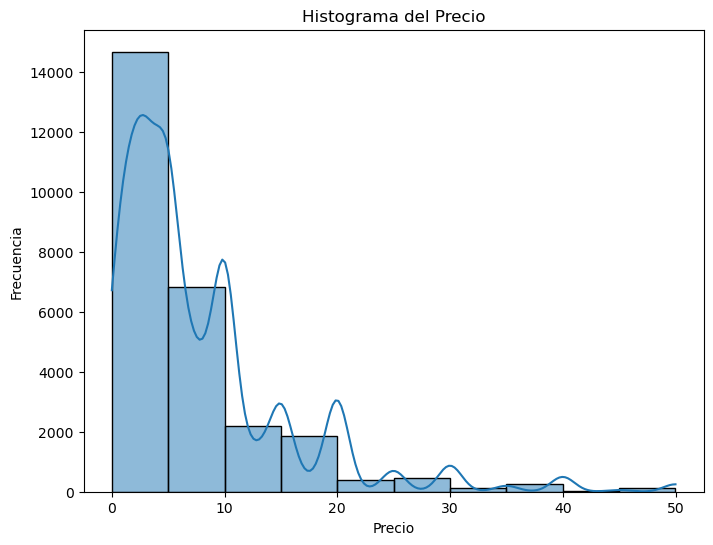

In [52]:
# Histograma
plt.figure(figsize=(8, 6))
sns.histplot(df_vars_wo['Precio'], bins=10, kde=True)
plt.title('Histograma del Precio')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')
plt.show()

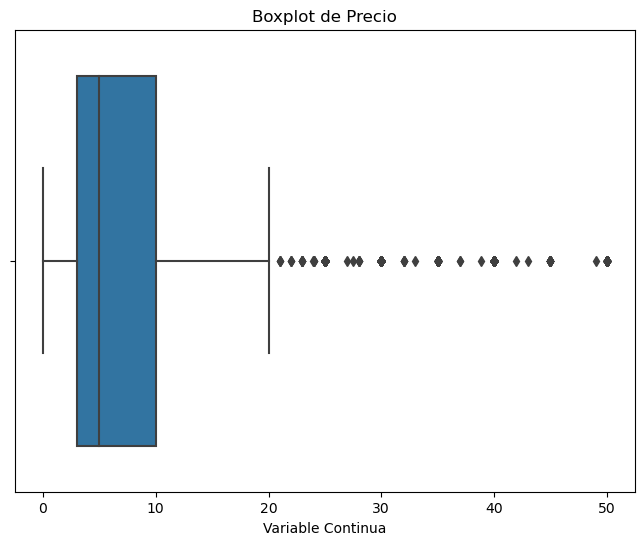

In [54]:
# Boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x=df_vars_wo['Precio'])
plt.title('Boxplot de Precio')
plt.xlabel('Variable Continua')
plt.show()

Vemos que por el lado del histograma y el boxplot ya es muchco mas visualizable. Aun así el boxplot muestra valores fuera del rango intercuantilico. Los dejaremos

# Caracteristicas

In [58]:
df_vars.set_index('id', inplace=True)
df_vars1 = df_vars.iloc[:, 0:-2]

In [67]:
df_specs = df_vars1[unique_list('specs')]
df_gen = df_vars1[unique_list('genres')]
df_tags = df_vars1[unique_list('tags')]

/var/folders/6s/zvsfwc9975gdw5pt_krwlbpm0000gn/T/ipykernel_10071/2788107322.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data[variable]=data[variable].str.replace('[',"")
/var/folders/6s/zvsfwc9975gdw5pt_krwlbpm0000gn/T/ipykernel_10071/2788107322.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data[variable]=data[variable].str.replace("]","")
/var/folders/6s/zvsfwc9975gdw5pt_krwlbpm0000gn/T/ipykernel_10071/2788107322.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data[variable]=data[variable].str.replace(

In [74]:
# Función para crear nube de palabras
def generar_nube_palabras(dataframe, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dataframe.sum())
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

## Especificaciones

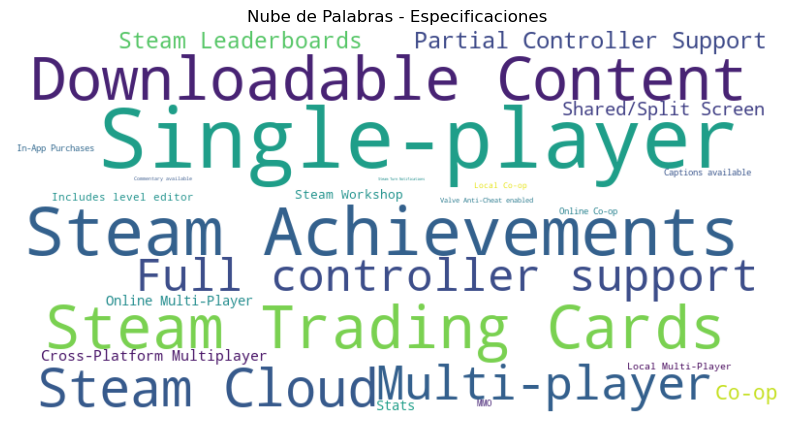

In [72]:
# Crear nube de palabras para df_specs
generar_nube_palabras(df_specs, 'Nube de Palabras - Especificaciones')

In [89]:
describe_specs = df_specs.describe().transpose()
describe_specs[['mean','std']]

,mean,std
Captions available,0.032463,0.177231
Commentary available,0.006073,0.077695
Online Multi-Player,0.076227,0.265365
Local Co-op,0.025029,0.156215
Includes Source SDK,0.001951,0.044125
Full controller support,0.248445,0.432119
Mods,0.000368,0.019182
Co-op,0.166292,0.372350
Game demo,0.000147,0.012133
Steam Cloud,0.346829,0.475970


Aproximadamente un 90% de los juegos son de un solo jugador y el 28% permite o es de multijugador. El 44,2% tiene un contenido descargable y el 56% tiene logros Steam

## Genero

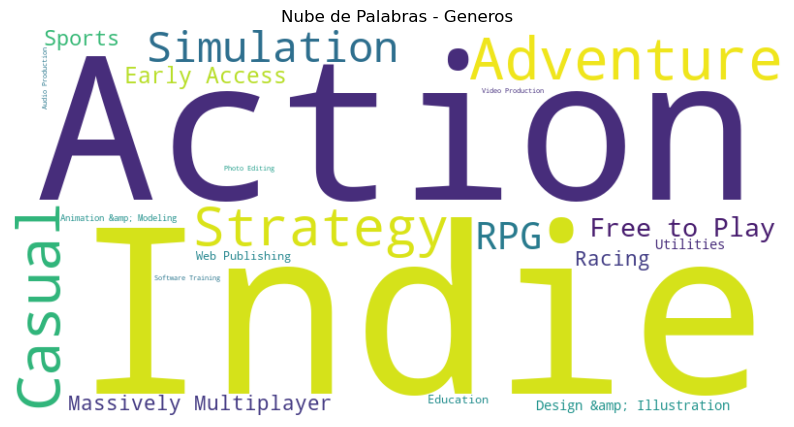

In [73]:
# Crear nube de palabras para df_gen
generar_nube_palabras(df_gen, 'Nube de Palabras - Generos')

In [90]:
describe_gen = df_gen.describe().transpose()
describe_gen[['mean','std']]

,mean,std
Action,0.412308,0.492259
Adventure,0.321322,0.466993
Animation &amp; Modeling,0.004527,0.067133
Education,0.008502,0.091817
Early Access,0.050462,0.218900
Racing,0.039935,0.195811
Massively Multiplayer,0.041297,0.198980
Free to Play,0.074202,0.262105
Sports,0.046156,0.209826
Casual,0.317678,0.465582


El 40% de los juegos es de accion, 26% de ellos de estrategia, el 32,1% es de aventuras. 25% son de simulacion

## Tags

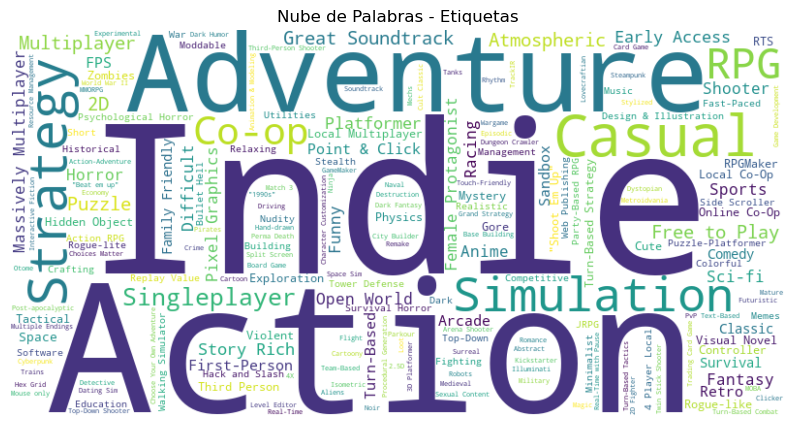

In [75]:
# Crear nube de palabras para df_tags
generar_nube_palabras(df_tags, 'Nube de Palabras - Etiquetas')

In [91]:
describe_tags = df_tags.describe().transpose()
describe_tags[['mean','std']]

,mean,std
Spectacle fighter,0.000994,0.031509
Fishing,0.000883,0.029709
Trading Card Game,0.002650,0.051412
Kickstarter,0.004343,0.065761
Racing,0.039935,0.195811
...,...,...
Tanks,0.002613,0.051054
Heist,0.001067,0.032654
Utilities,0.014649,0.120146
Real Time Tactics,0.002208,0.046943
